In [2]:
# Importo las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import math
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import linkage, dendrogram
from kmodes.kmodes import KModes
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import nltk

In [3]:
# Cargar del dataset
url = 'https://raw.githubusercontent.com/Marian2057/TrabajoFinal-CR/main/BaseCRold.xlsx'
base = pd.read_excel(url, engine='openpyxl')

El set de datos corresponde a los datos de productores beneficiarios del Programa Cambio Rural.
Dentro del conjunto de datos disponibles de esos beneficiarios se escogieron inicialmente la región,
provincia, sexo, edad, rango etario, educación, porcentaje de ingresos mensuales que aporta el
emprendimiento acompañado por CR, situación AFIP, caracterización (variables construida en base a
ciertos datos del productor y la superficie que ocupa para ese emprendimiento específico.
Del análisis exploratorio inicial, surge que el dataset cuenta con 13391 observaciones y las 10
columnas/variables mencionadas, de las cuales 8 son categóricas y 2 son cuantitativas. Se observan
también datos faltantes en algunas de ellas.

## Exploración del Dataset

In [4]:
# Exploración del dataset
base.head(5)

,Coordinación,Provincia,Sexo,Edad,Rango_etario,Educación,Ingresos,SituacionAFIP,Caracterización,superficie
0,NOA,Jujuy,Femenino,NaN,Menor de 30,Ninguna,Menos del 30%,NaN,Productor familiar capitalizado,0
1,Patagonia,Chubut,Femenino,NaN,Menor de 30,Ninguna,Más del 50%,Responsable Inscripto,Productor familiar capitalizado,0
2,Centro,Córdoba,Femenino,NaN,Menor de 30,Ninguna,Más del 50%,Responsable Inscripto,Productor familiar capitalizado,0
3,Bs As-La Pampa,Buenos Aires,Masculino,NaN,Menor de 30,Ninguna,Más del 50%,Monotributo Cat B,Productor familiar capitalizado,0
4,Patagonia,Chubut,Masculino,NaN,Menor de 30,Ninguna,Más del 50%,Monotributo Cat C,Productor familiar capitalizado,300


In [5]:
print(f"Dimensión del dataset {base.shape}")

Dimensión del dataset (13391, 10)


In [6]:
print("Variables del dataset \n")
base.info()

Variables del dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13391 entries, 0 to 13390
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Coordinación     13391 non-null  object 
 1   Provincia        13391 non-null  object 
 2   Sexo             13391 non-null  object 
 3   Edad             12989 non-null  float64
 4   Rango_etario     13391 non-null  object 
 5   Educación        13391 non-null  object 
 6   Ingresos         13391 non-null  object 
 7   SituacionAFIP    12389 non-null  object 
 8   Caracterización  13391 non-null  object 
 9   superficie       13391 non-null  int64  
dtypes: float64(1), int64(1), object(8)
memory usage: 1.0+ MB


## Limpiando los datos

### **Variables categóricas

Luego de una exploración breve de las variables categóricas, siendo el objetivo de este trabajo la
identificación de un “Perfil de beneficiario”, llegamos a la conclusión de que las variables de ubicación
geográfica no aportaban mayor información, ya que el Programa es de alcance nacional. Queda
eventualmente la posibilidad de incorporarlas, luego, para verificar si aportan o no algo de información.
La variable “sexo” tampoco aporta mucha información ya que sabemos de antemano que los varones son
amplia mayoría. Se la podrá incorporar más adelante para evaluar si aporta o no.
Dejaremos fuera la variable “caracterización” ya que es una construcción que realiza el Sistema de Gestión
del Programa y no queremos que influya en la detección de patrones subyacentes.

### **Variables cuantitativas

Comenzamos el análisis de las cuantitativas para evaluar su utilidad para la generación de clusters.
El estudio de la variable superficie muestra mucha dispersión en los datos con un rango de 50.000 Has, y la
suposición de que se trata de errores de carga ya que la caracterización de los beneficiarios oscila entre
productores familiares en vías de ser capitalizados y PYMES. Así mismo, dentro de los beneficiarios hay
quienes tienen actividades tales como servicios, turismo u otras, que no requieren de la explotación de
tierras por lo que la superficie utilizada tiene un valor genuino de cero.
En este punto, vemos que uno de los métodos más comunes para lidiar con grandes rangos como lo es el
uso de logaritmos, se ve afectado por ser una función que no está definida en el cero. La posibilidad de
sustituir por la media no nos pareció adecuada en estas circunstancias. Otro tema del cual ocuparse son los
NaN.
Se pensó como alternativa la utilización de una función partida para el uso del logaritmo, donde la función
es 0 para x=0; Null para x=NaN y Log(x) para x&gt;0. En este caso tendríamos además una “sobrecarga” de
ceros, por los ceros genuinos y los provocados por el log(1). se decidió trabajar con las siguientes variables categoricas Rango etario, educación, ingresos y situación AFIP.

In [7]:
base_nueva = base[['Rango_etario', 'Educación', 'Ingresos', 'SituacionAFIP']]
base_nueva.head()

,Rango_etario,Educación,Ingresos,SituacionAFIP
0,Menor de 30,Ninguna,Menos del 30%,NaN
1,Menor de 30,Ninguna,Más del 50%,Responsable Inscripto
2,Menor de 30,Ninguna,Más del 50%,Responsable Inscripto
3,Menor de 30,Ninguna,Más del 50%,Monotributo Cat B
4,Menor de 30,Ninguna,Más del 50%,Monotributo Cat C


*** reemplazamos los nan por el valor no declarado asi no perdemos datos en la base


In [8]:
# reemplazamos los nan por el valor no declarado
base_nueva.fillna("No declarado", inplace=True)
base_nueva.head()

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_22692\3696999269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_nueva.fillna("No declarado", inplace=True)


,Rango_etario,Educación,Ingresos,SituacionAFIP
0,Menor de 30,Ninguna,Menos del 30%,No declarado
1,Menor de 30,Ninguna,Más del 50%,Responsable Inscripto
2,Menor de 30,Ninguna,Más del 50%,Responsable Inscripto
3,Menor de 30,Ninguna,Más del 50%,Monotributo Cat B
4,Menor de 30,Ninguna,Más del 50%,Monotributo Cat C


In [9]:
# Exploro las variables categóricas

print("Valores que toman las variables \n")

print("Rango Etario: ", set(base_nueva["Rango_etario"]), "\n Ítems: ", len(set(base_nueva["Rango_etario"])),'\n')
print("Nivel de Educación: ", set(base_nueva["Educación"]), "\n Ítems: ", len(set(base_nueva["Educación"])),'\n')
print("Ingresos por la Actividad: ", set(base_nueva["Ingresos"]), "\n Ítems: ", len(set(base_nueva["Ingresos"])),'\n')
print("Situación AFIP: ", set(base_nueva["SituacionAFIP"]), "\n Ítems: ", len(set(base_nueva["SituacionAFIP"])),'\n')


Valores que toman las variables 

Rango Etario:  {'De 46 a 55', 'Más de 55', 'Menor de 30', 'De 31 a 45'} 
 Ítems:  4 

Nivel de Educación:  {' Terciario', ' Ninguna', ' Postgrado', ' Primario', ' Universitario', ' Secundario'} 
 Ítems:  6 

Ingresos por la Actividad:  {'Entre 30% y 50%', 'Menos del 30%', 'Más del 50%'} 
 Ítems:  3 

Situación AFIP:  {'Monotributo Cat F', 'Monotributo Cat B', 'Monotributo Cat A', 'Monotributo Cat I', 'Monotributo Cat E', 'Monotributo Cat H', 'Monotributo Cat D', 'No declarado', 'Monotributo Cat K', 'No responsable', 'Monotributo Cat C', 'Responsable no inscripto', 'Sujeto exento', 'Monotributo Cat J', 'Responsable Inscripto', 'Monotributo social', 'Monotributo Cat G'} 
 Ítems:  17 



In [10]:
base_nueva.describe()

,Rango_etario,Educación,Ingresos,SituacionAFIP
count,13391,13391,13391,13391
unique,4,6,3,17
top,Más de 55,Secundario,Más del 50%,Responsable Inscripto
freq,5326,5510,5808,3909


In [11]:
base_nueva.nunique()

Rango_etario      4
Educación         6
Ingresos          3
SituacionAFIP    17
dtype: int64

In [12]:
# confirmamos que no tenemos valores nulos
base_nueva.isnull().sum()*100/base_nueva.shape[0]

Rango_etario     0.0
Educación        0.0
Ingresos         0.0
SituacionAFIP    0.0
dtype: float64

## Construcción del Modelo
Nuestro objetivo en este cuaderno es solo demostrar el algoritmo K-modes, y omitiremos en esta ocación el EDA y nos pasaremos directamente a la construcción del modelo


*** Contrucción del modelo
Convertimos las variables categoricas a numericas

In [13]:
# Ordeanamos las categorías de las variables categóricas ordinales 
rango_etario_map = {'Menor de 30': 0, 'De 31 a 45': 1, 'De 46 a 55': 2, 'Más de 55': 3}
nivel_educacion_map = {' Ninguna': 0, ' Primario': 1, ' Secundario': 2, ' Terciario': 3, ' Universitario': 4, ' Postgrado': 5}
ingresos_actividad_map = {'Menos del 30%': 0, 'Entre 30% y 50%': 1, 'Más del 50%': 2}
situacion_afip_map = {'No declarado': 0, 'No responsable': 1, 'Responsable no inscripto': 2, 'Responsable Inscripto': 3, 'Sujeto exento': 4, 'Monotributo social': 5, 'Monotributo Cat A': 6, 'Monotributo Cat B': 7, 'Monotributo Cat C': 8, 'Monotributo Cat D': 9, 'Monotributo Cat E': 10, 'Monotributo Cat F': 11, 'Monotributo Cat G': 12, 'Monotributo Cat H': 13, 'Monotributo Cat I': 14, 'Monotributo Cat J': 15, 'Monotributo Cat K': 16}

# Creamos las nuevas columnas numéricas para cada variable
base_nueva['Rango_etarioNum'] = base_nueva['Rango_etario'].map(rango_etario_map)
base_nueva['EducacionNum'] = base_nueva['Educación'].map(nivel_educacion_map)
base_nueva['IngresosNum'] = base_nueva['Ingresos'].map(ingresos_actividad_map)
base_nueva['SituacionAFIPNum'] = base_nueva['SituacionAFIP'].map(situacion_afip_map)

# Verificamos que las nuevas columnas se hayan agregado correctamente
base_nueva.head(5)


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_22692\4198858051.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_nueva['Rango_etarioNum'] = base_nueva['Rango_etario'].map(rango_etario_map)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_22692\4198858051.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_nueva['EducacionNum'] = base_nueva['Educación'].map(nivel_educacion_map)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_22692\4198858051.py:10: SettingWith

,Rango_etario,Educación,Ingresos,SituacionAFIP,Rango_etarioNum,EducacionNum,IngresosNum,SituacionAFIPNum
0,Menor de 30,Ninguna,Menos del 30%,No declarado,0,0,0,0
1,Menor de 30,Ninguna,Más del 50%,Responsable Inscripto,0,0,2,3
2,Menor de 30,Ninguna,Más del 50%,Responsable Inscripto,0,0,2,3
3,Menor de 30,Ninguna,Más del 50%,Monotributo Cat B,0,0,2,7
4,Menor de 30,Ninguna,Más del 50%,Monotributo Cat C,0,0,2,8


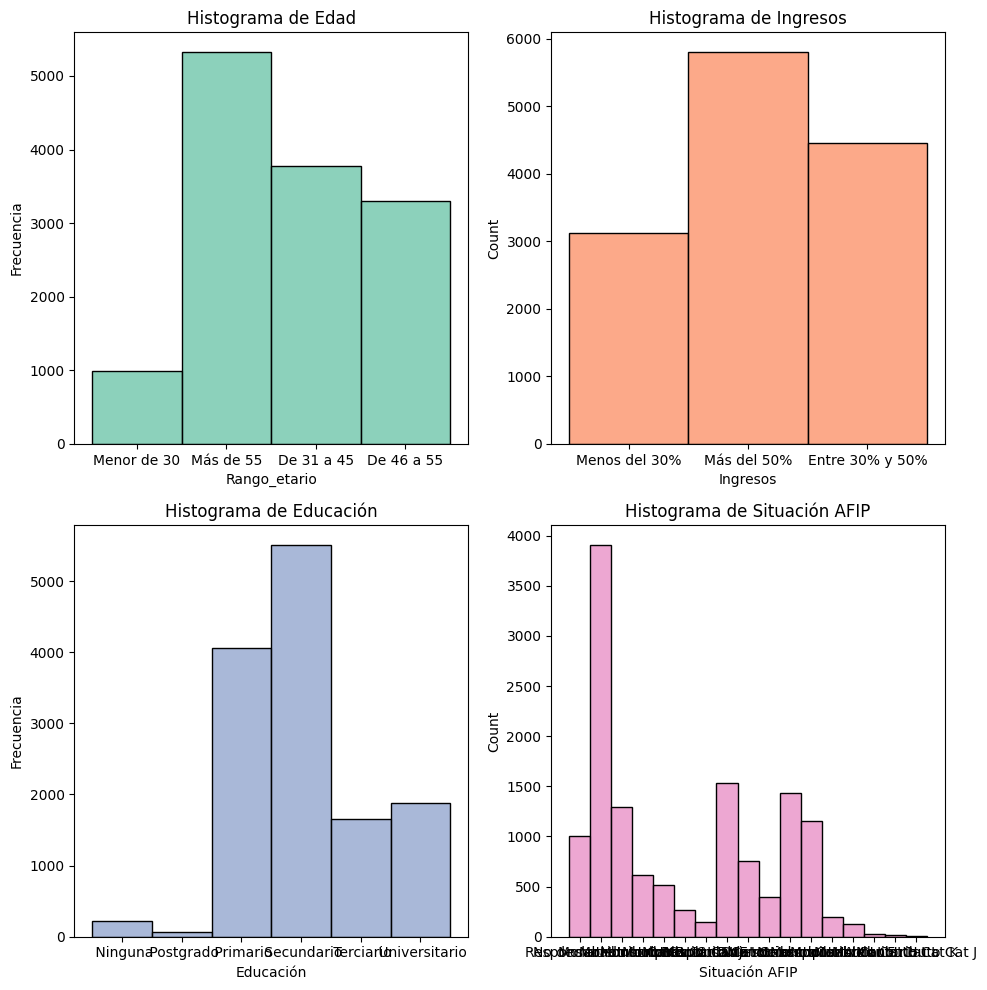

In [14]:
# Crear la figura y los subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Especificar la paleta de colores
palette = sns.color_palette("Set2", n_colors=8)

# Crear los histogramas para cada variable y asignarles un color diferente
sns.histplot(base_nueva, x='Rango_etario', bins=10, color=palette[0], ax=axs[0, 0])
sns.histplot(base_nueva, x='Ingresos', bins=10, color=palette[1], ax=axs[0, 1])
sns.histplot(base_nueva, x='Educación', bins=10, color=palette[2], ax=axs[1, 0])
sns.histplot(base_nueva, x='SituacionAFIP', bins=10, color=palette[3], ax=axs[1, 1])

# Ajustar los títulos y los ejes de cada subplot
axs[0, 0].set_title('Histograma de Edad')
axs[0, 1].set_title('Histograma de Ingresos')
axs[1, 0].set_title('Histograma de Educación')
axs[1, 1].set_title('Histograma de Situación AFIP')
axs[0, 0].set_ylabel('Frecuencia')
axs[1, 0].set_ylabel('Frecuencia')
axs[1, 0].set_xlabel('Educación')
axs[1, 1].set_xlabel('Situación AFIP')

# Ajustar el espacio entre subplots y mostrar la figura
fig.tight_layout()
plt.show()

<Axes: xlabel='Educación', ylabel='count'>

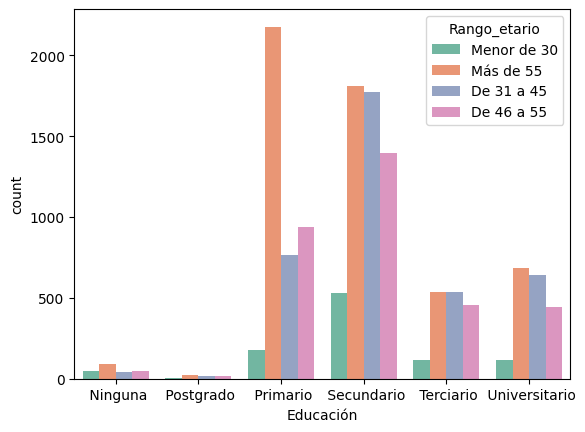

In [15]:
# Este gráfico te permitirá visualizar cuántos individuos hay en cada nivel de educación y rango etario, y cómo se distribuyen en cada categoría.

sns.set_palette('Set2') # establece una paleta de colores
sns.countplot(x='Educación', hue='Rango_etario', data=base_nueva)

<Axes: xlabel='Rango_etario', ylabel='count'>

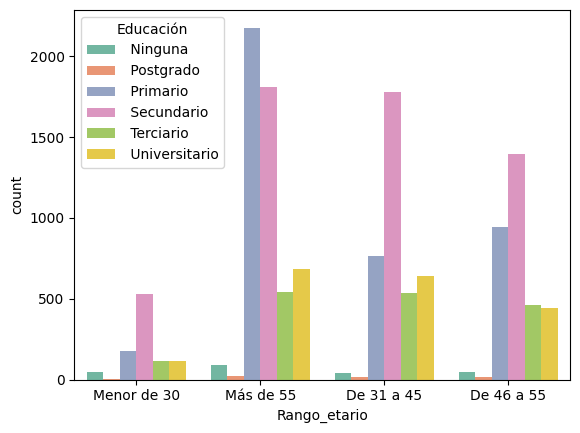

In [16]:
sns.set_palette('Set2') # establece una paleta de colores
sns.countplot(x='Rango_etario', hue='Educación', data=base_nueva)

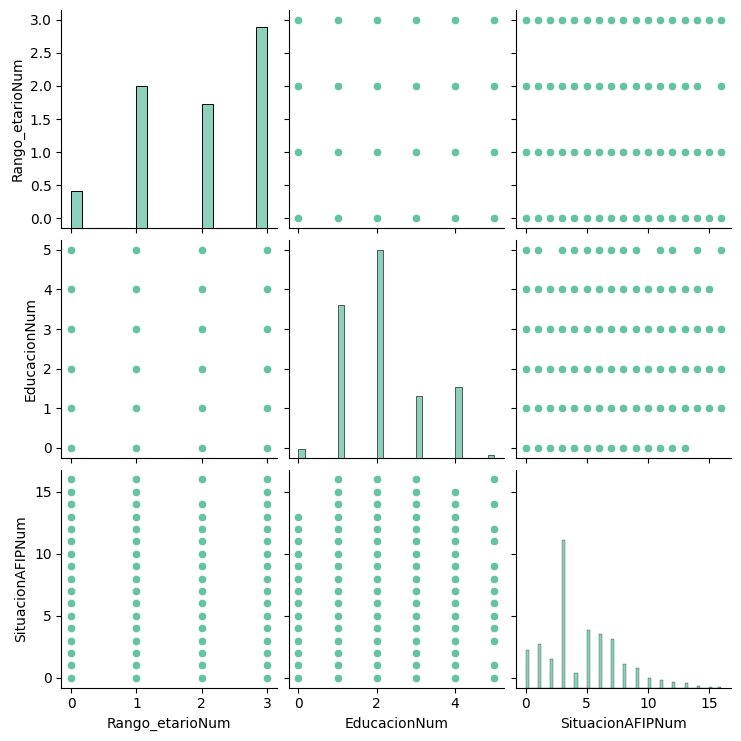

In [17]:
#Este código creará un gráfico de matriz de dispersión que muestra la relación entre las tres variables en el marco base_nueva. La diagonal muestra histogramas de cada variable individual, mientras que las otras celdas muestran gráficos de dispersión bidimensionales que muestran la relación entre dos variables. Además, puedes agregar el argumento hue a la función pairplot para agregar una cuarta variable como una variable de color que resalta los diferentes grupos o categorías.

sns.pairplot(base_nueva[['Rango_etarioNum', 'EducacionNum', 'SituacionAFIPNum']])


<Axes: >

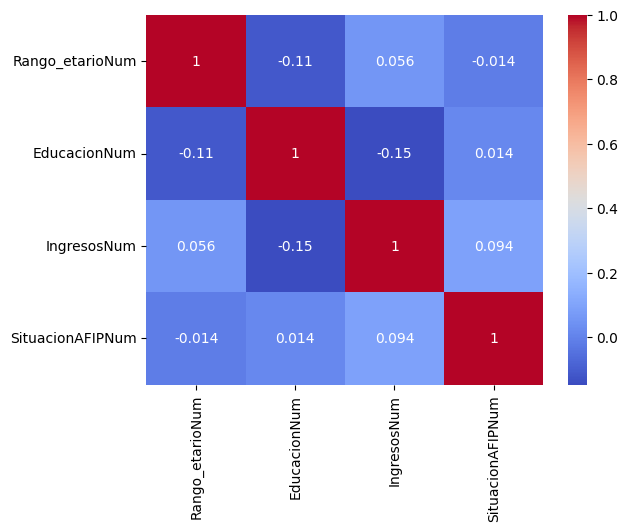

In [18]:
# Calcular la matriz de correlación
corr_matrix = base_nueva.iloc[:,4:8].corr()

# Generar el mapa de calor con seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

## Comenzamos a utilizar los métodos para clusterizar

## ------------- K-MODES ---------------

### Usando K-Modes con Inicialización "CAO"

In [19]:
# Establezco un epsilon para calibrar el método
epsilon = 5000

In [20]:
# Construyo el modelo K-MODES con inicialización CAO
km_cao = KModes(n_clusters=2, init = "Cao", max_iter = epsilon, n_init = 5, verbose=1)

# prediccion de clusters
fitClusters_cao = km_cao.fit_predict(base_nueva.iloc[:,4:8]) # Utilizamos la parte codificada de la base
fitClusters_cao
clusterCentroid_C = pd.DataFrame(km_cao.cluster_centroids_)
clusterCentroid_C.columns = base_nueva.iloc[:,4:8].columns

# Mode of the clusters
clusterCentroid_C

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/5000, moves: 0, cost: 27363.0


,Rango_etarioNum,EducacionNum,IngresosNum,SituacionAFIPNum
0,3,2,2,3
1,1,1,1,5


### Usando K-Modes con Inicialización "Huang"

In [21]:
### Construyo el modelo K-MODES con inicialización Huang
km_huang = KModes(n_clusters=2, init = "Huang", max_iter = epsilon, n_init = 5, verbose=1)

# prediccion de clusters
fitClusters_huang = km_huang.fit_predict(base_nueva.iloc[:,4:8]) # Utilizamos la parte codificada de la base
fitClusters_huang
clusterCentroid_H = pd.DataFrame(km_huang.cluster_centroids_)
clusterCentroid_H.columns = base_nueva.iloc[:,4:8].columns

# Mode of the clusters
clusterCentroid_H

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/5000, moves: 3870, cost: 28497.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/5000, moves: 0, cost: 29063.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/5000, moves: 0, cost: 32394.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/5000, moves: 1742, cost: 29711.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/5000, moves: 4389, cost: 27749.0
Best run was number 5


,Rango_etarioNum,EducacionNum,IngresosNum,SituacionAFIPNum
0,3,1,2,3
1,1,2,2,3


In [22]:
# Agrega los clusters generados por CAO y Huang como columnas al dataframe original

print(f'Epsilon = {epsilon} \n')

base_nueva.loc[:,'cluster_CAO'] = fitClusters_cao
cluster_counts_CAO = base_nueva["cluster_CAO"].value_counts()
print(f'Clusers generados por CAO \n{cluster_counts_CAO} \n')

base_nueva.loc[:,'cluster_Huang'] = fitClusters_huang
cluster_counts_Huang = base_nueva["cluster_Huang"].value_counts()
print(f'Clusers generados por Huang \n{cluster_counts_Huang} \n')

Epsilon = 5000 

Clusers generados por CAO 
cluster_CAO
0    9639
1    3752
Name: count, dtype: int64 

Clusers generados por Huang 
cluster_Huang
0    8454
1    4937
Name: count, dtype: int64 



C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_22692\2459732799.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_nueva.loc[:,'cluster_CAO'] = fitClusters_cao


In [23]:
# Me fijo dónde quedaron los centroides de cada init
print(f'Centroides de los clusters generados por CAO \n{clusterCentroid_C} \n')
print(f'Centroides de los clusters generados por HUANG \n{clusterCentroid_H} \n')

Centroides de los clusters generados por CAO 
   Rango_etarioNum  EducacionNum  IngresosNum  SituacionAFIPNum
0                3             2            2                 3
1                1             1            1                 5 

Centroides de los clusters generados por HUANG 
   Rango_etarioNum  EducacionNum  IngresosNum  SituacionAFIPNum
0                3             1            2                 3
1                1             2            2                 3 



In [24]:
# Agrego los clusters a la base
base_nueva.head(5)

,Rango_etario,Educación,Ingresos,SituacionAFIP,Rango_etarioNum,EducacionNum,IngresosNum,SituacionAFIPNum,cluster_CAO,cluster_Huang
0,Menor de 30,Ninguna,Menos del 30%,No declarado,0,0,0,0,0,0
1,Menor de 30,Ninguna,Más del 50%,Responsable Inscripto,0,0,2,3,0,0
2,Menor de 30,Ninguna,Más del 50%,Responsable Inscripto,0,0,2,3,0,0
3,Menor de 30,Ninguna,Más del 50%,Monotributo Cat B,0,0,2,7,0,0
4,Menor de 30,Ninguna,Más del 50%,Monotributo Cat C,0,0,2,8,0,0


### Características de los clusters

CAO

In [25]:
Cluster_0_CAO = base_nueva[base_nueva['cluster_CAO'] == 0]
Cluster_1_CAO = base_nueva[base_nueva['cluster_CAO'] == 1]
Cluster_2_CAO = base_nueva[base_nueva['cluster_CAO'] == 2]
Cluster_3_CAO = base_nueva[base_nueva['cluster_CAO'] == 3]
Cluster_4_CAO = base_nueva[base_nueva['cluster_CAO'] == 4]

In [26]:
print(Cluster_0_CAO["Rango_etario"].describe())
print(Cluster_0_CAO["Educación"].describe())
print(Cluster_0_CAO["Ingresos"].describe())
print(Cluster_0_CAO["SituacionAFIP"].describe())

count          9639
unique            4
top       Más de 55
freq           4669
Name: Rango_etario, dtype: object
count            9639
unique              6
top        Secundario
freq             4871
Name: Educación, dtype: object
count            9639
unique              3
top       Más del 50%
freq             5363
Name: Ingresos, dtype: object
count                      9639
unique                       17
top       Responsable Inscripto
freq                       3742
Name: SituacionAFIP, dtype: object


In [27]:
print(Cluster_1_CAO["Rango_etario"].describe())
print(Cluster_1_CAO["Educación"].describe())
print(Cluster_1_CAO["Ingresos"].describe())
print(Cluster_1_CAO["SituacionAFIP"].describe())

count           3752
unique             4
top       De 31 a 45
freq            2059
Name: Rango_etario, dtype: object
count          3752
unique            6
top        Primario
freq           1993
Name: Educación, dtype: object
count                3752
unique                  3
top       Entre 30% y 50%
freq                 2529
Name: Ingresos, dtype: object
count                   3752
unique                    17
top       Monotributo social
freq                     975
Name: SituacionAFIP, dtype: object


In [28]:
print(Cluster_2_CAO["Rango_etario"].describe())
print(Cluster_2_CAO["Educación"].describe())
print(Cluster_2_CAO["Ingresos"].describe())
print(Cluster_2_CAO["SituacionAFIP"].describe())

count       0
unique      0
top       NaN
freq      NaN
Name: Rango_etario, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: Educación, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: Ingresos, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: SituacionAFIP, dtype: object


In [29]:
print(Cluster_3_CAO["Rango_etario"].describe())
print(Cluster_3_CAO["Educación"].describe())
print(Cluster_3_CAO["Ingresos"].describe())
print(Cluster_3_CAO["SituacionAFIP"].describe())

count       0
unique      0
top       NaN
freq      NaN
Name: Rango_etario, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: Educación, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: Ingresos, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: SituacionAFIP, dtype: object


In [30]:
print(Cluster_4_CAO["Rango_etario"].describe())
print(Cluster_4_CAO["Educación"].describe())
print(Cluster_4_CAO["Ingresos"].describe())
print(Cluster_4_CAO["SituacionAFIP"].describe())

count       0
unique      0
top       NaN
freq      NaN
Name: Rango_etario, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: Educación, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: Ingresos, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: SituacionAFIP, dtype: object


HUANG

In [31]:
Cluster_0_HUANG = base_nueva[base_nueva['cluster_Huang'] == 0]
Cluster_1_HUANG = base_nueva[base_nueva['cluster_Huang'] == 1]
Cluster_2_HUANG = base_nueva[base_nueva['cluster_Huang'] == 2]
Cluster_3_HUANG = base_nueva[base_nueva['cluster_Huang'] == 3]
Cluster_4_HUANG = base_nueva[base_nueva['cluster_Huang'] == 4]

In [32]:
print(Cluster_0_HUANG["Rango_etario"].describe())
print(Cluster_0_HUANG["Educación"].describe())
print(Cluster_0_HUANG["Ingresos"].describe())
print(Cluster_0_HUANG["SituacionAFIP"].describe())

count          8454
unique            4
top       Más de 55
freq           5326
Name: Rango_etario, dtype: object
count          8454
unique            6
top        Primario
freq           4059
Name: Educación, dtype: object
count            8454
unique              3
top       Más del 50%
freq             3771
Name: Ingresos, dtype: object
count                      8454
unique                       17
top       Responsable Inscripto
freq                       2651
Name: SituacionAFIP, dtype: object


In [33]:
print(Cluster_1_HUANG["Rango_etario"].describe())
print(Cluster_1_HUANG["Educación"].describe())
print(Cluster_1_HUANG["Ingresos"].describe())
print(Cluster_1_HUANG["SituacionAFIP"].describe())

count           4937
unique             3
top       De 31 a 45
freq            3012
Name: Rango_etario, dtype: object
count            4937
unique              5
top        Secundario
freq             3701
Name: Educación, dtype: object
count            4937
unique              3
top       Más del 50%
freq             2037
Name: Ingresos, dtype: object
count                      4937
unique                       17
top       Responsable Inscripto
freq                       1258
Name: SituacionAFIP, dtype: object


In [34]:
print(Cluster_2_HUANG["Rango_etario"].describe())
print(Cluster_2_HUANG["Educación"].describe())
print(Cluster_2_HUANG["Ingresos"].describe())
print(Cluster_2_HUANG["SituacionAFIP"].describe())

count       0
unique      0
top       NaN
freq      NaN
Name: Rango_etario, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: Educación, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: Ingresos, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: SituacionAFIP, dtype: object


In [35]:
print(Cluster_3_HUANG["Rango_etario"].describe())
print(Cluster_3_HUANG["Educación"].describe())
print(Cluster_3_HUANG["Ingresos"].describe())
print(Cluster_3_HUANG["SituacionAFIP"].describe())

count       0
unique      0
top       NaN
freq      NaN
Name: Rango_etario, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: Educación, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: Ingresos, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: SituacionAFIP, dtype: object


In [36]:
print(Cluster_4_HUANG["Rango_etario"].describe())
print(Cluster_4_HUANG["Educación"].describe())
print(Cluster_4_HUANG["Ingresos"].describe())
print(Cluster_4_HUANG["SituacionAFIP"].describe())

count       0
unique      0
top       NaN
freq      NaN
Name: Rango_etario, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: Educación, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: Ingresos, dtype: object
count       0
unique      0
top       NaN
freq      NaN
Name: SituacionAFIP, dtype: object


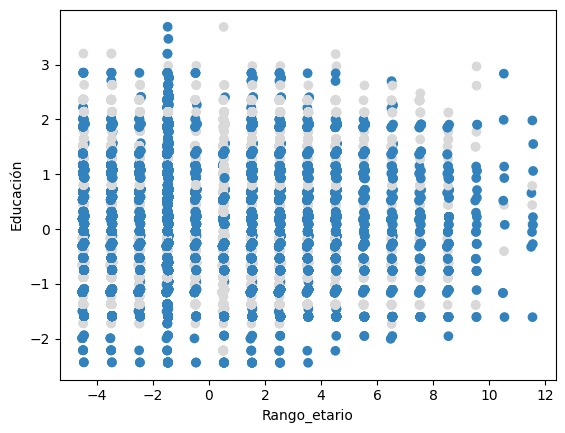

In [37]:
# Para visualizar los puntos en el espacio de dos dimensiones, puedes utilizar una técnica de reducción de dimensionalidad 
# como el Análisis de Componentes Principales (PCA) o el t-SNE. Estas técnicas te permiten proyectar los datos en un espacio 
# de dos dimensiones de tal manera que se preserva la estructura de similitud entre los puntos en el espacio original. Luego 
# puedes utilizar un gráfico de dispersión para visualizar los puntos en el espacio de dos dimensiones y colorearlos según su 
# etiqueta de cluster para ver si existe alguna estructura en los datos.
# Esto te mostrará un gráfico de dispersión de los datos reducidos a dos dimensiones utilizando PCA, donde cada punto está 
# coloreado según su etiqueta de cluster. Si existen estructuras en los datos, deberías ver grupos de puntos con el mismo 
# color cerca unos de otros.


# Crear una instancia de PCA con 2 componentes
pca = PCA(n_components=2)

# Aplicar PCA a los datos
pca_encoded = pca.fit_transform(base_nueva.iloc[:,4:8])

# Crear un gráfico de dispersión de los datos reducidos a 2 dimensiones y colorear los puntos según su etiqueta de cluster
plt.scatter(pca_encoded[:, 0], pca_encoded[:, 1], c=fitClusters_cao, cmap='tab20c')
plt.xlabel('Rango_etario')
plt.ylabel('Educación')
plt.show()

<Axes: >

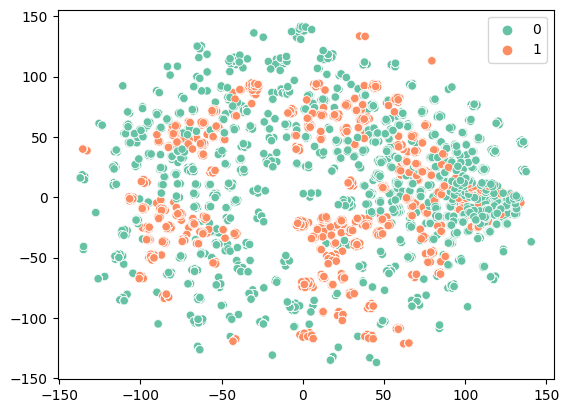

In [38]:
# Este código aplicará t-SNE con 2 componentes, una perplexidad de 30 y una semilla aleatoria de 42, a los datos codificados 
# en encoded_base. Luego, creará un scatterplot con los puntos en el espacio reducido por t-SNE, coloreando los puntos según 
# el cluster al que pertenecen. Así, podrás visualizar si hay patrones o agrupaciones de puntos en los datos.


# Crear una instancia de TSNE con los parámetros deseados
tsne = TSNE(n_components=2, perplexity=30, random_state=42)

# Aplicar TSNE a tus datos
embedded_data = tsne.fit_transform(base_nueva.iloc[:,4:8])

# Crear un scatterplot con los puntos en el espacio reducido por TSNE, coloreando los puntos por el cluster al que pertenecen
sns.scatterplot(x=embedded_data[:, 0], y=embedded_data[:, 1], hue=fitClusters_cao)


Si utilizamos un gráfico de Dendrograma para ver cómo se organizan los datos jerárquicamente y también encontramos que se generan dos ramas, de las cuales una es bastante más munerosa. Lamentablemente los caonceptos adquiridos hasta aquí, no nos permiten un análisis más profundo sobr esto, salvo que se parece más a la clasificación hecha con K- Modes inicializado CAO.

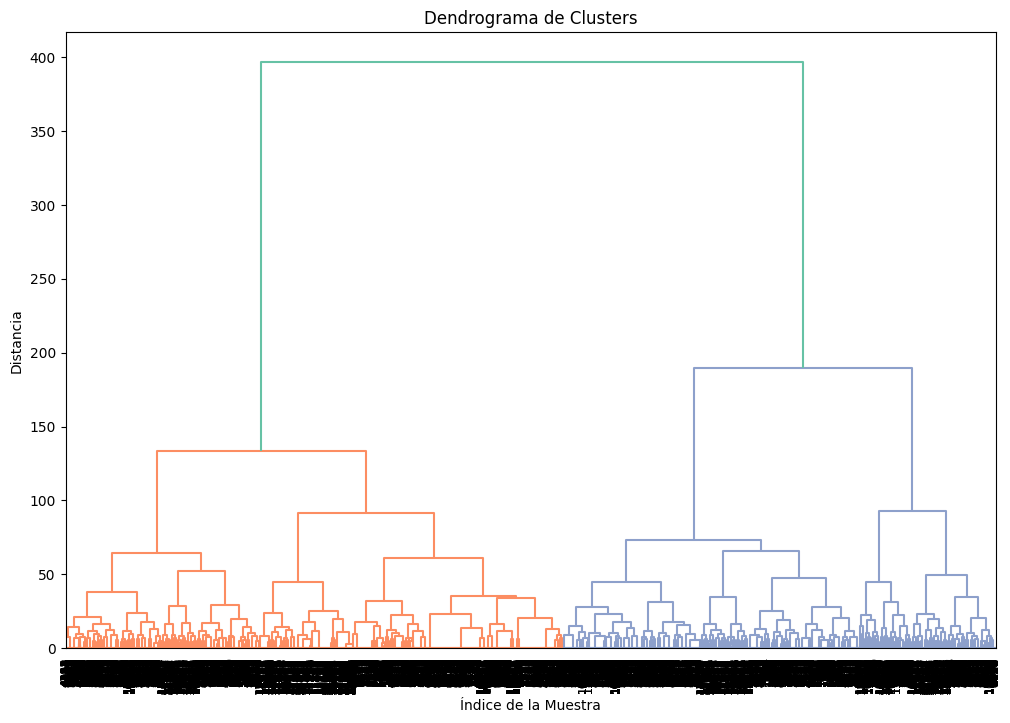

In [39]:
# Calcular la matriz de enlace
Z = linkage(base_nueva.iloc[:,4:8], method='ward')

# Crear el dendrograma
plt.figure(figsize=(12, 8))
plt.title('Dendrograma de Clusters')
plt.xlabel('Índice de la Muestra')
plt.ylabel('Distancia')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
plt.show()

Gráfico de dispersión, donde se representan los valores de "IngresosNum" en el eje x y "EducacionNum" en el eje y. Los puntos en el gráfico se colorean según el valor del cluster "cluster_CAO"

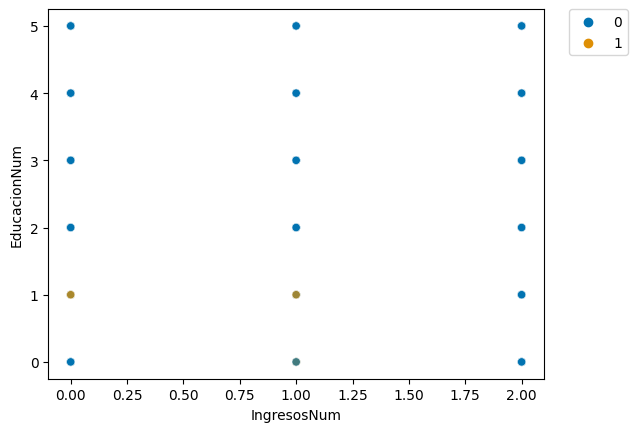

In [40]:
# Pruebo con un gráfico de dispersión entre dos de las variabes para ver cómo se comportan con CAO
sns.scatterplot(data=base_nueva, x="IngresosNum", y="EducacionNum", hue="cluster_CAO", palette="colorblind", alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Gráfico de dispersión, donde se representan los valores de "IngresosNum" en el eje x y "SituacionAFIPNum" en el eje y. Los puntos en el gráfico se colorean según el valor del cluster "cluster_Huang"

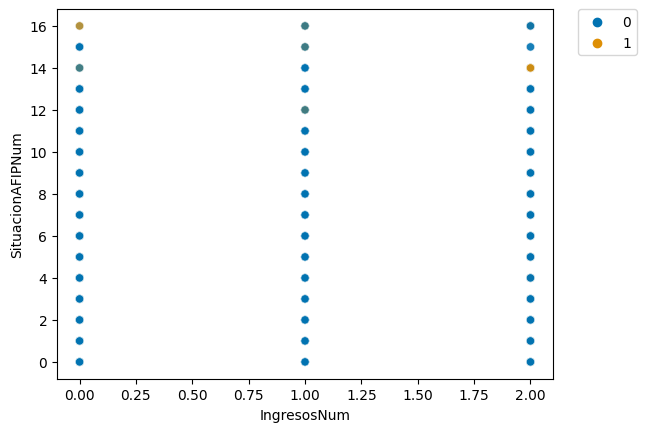

In [41]:
# Pruebo con un gráfico de dispersión entre dos de las variabes para ver cómo se comportan con Huang
sns.scatterplot(data=base_nueva, x="IngresosNum", y="SituacionAFIPNum", hue="cluster_Huang", palette="colorblind", alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

En los gráficos de dispersion e histogramas podemos visualiza las relaciones entre las variables "Rango_etarioNum", "EducacionNum", "IngresosNum" y "SituacionAFIPNum". Los puntos en los gráficos se agrupan y se colorean según el valor del cluster "cluster_CAO". Además, los gráficos diagonales muestran histogramas en lugar de gráficos de dispersión, y los puntos en los gráficos de dispersión se representan con el símbolo "+". Esto proporciona una visión general de las relaciones entre las variables y las distribuciones individuales de cada variable en el conjunto de datos.

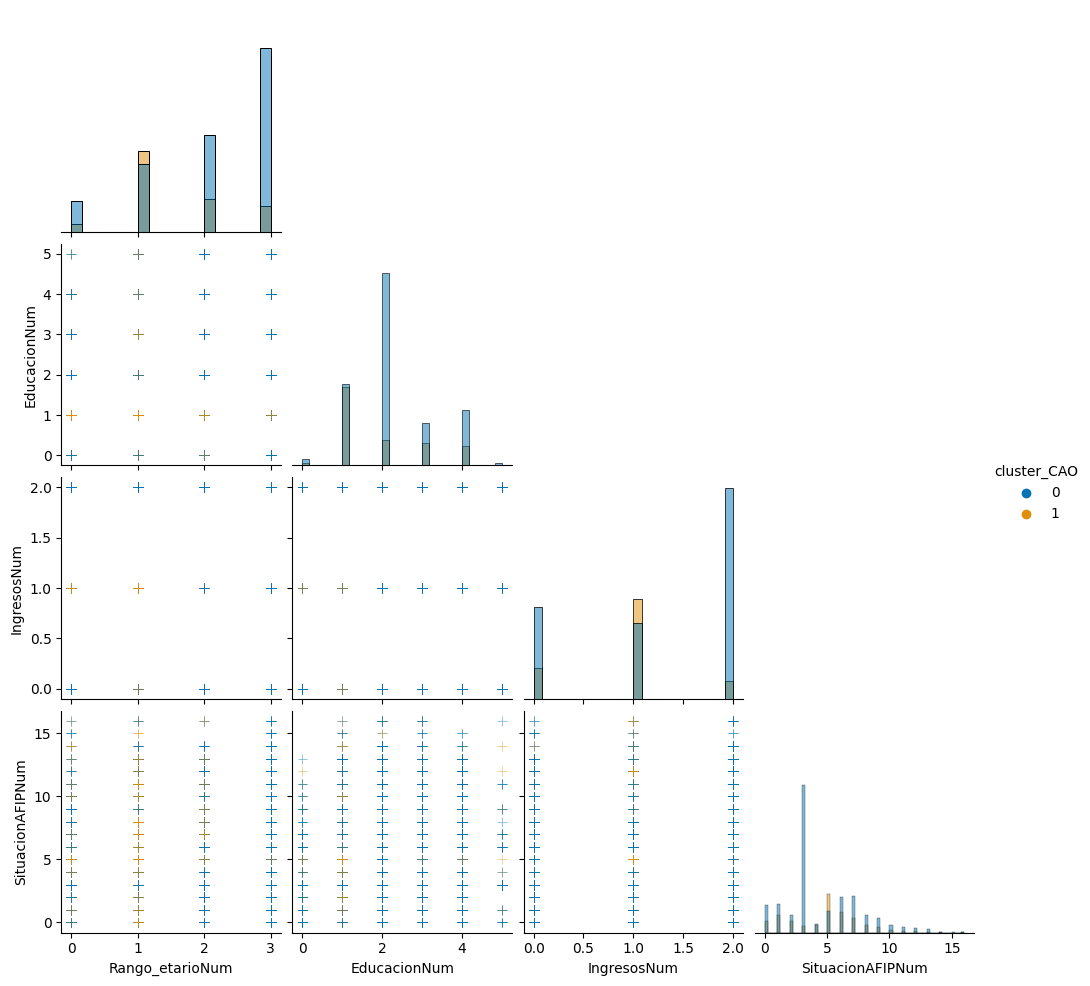

In [42]:
sns.pairplot(data=base_nueva, vars=["Rango_etarioNum", "EducacionNum", "IngresosNum", "SituacionAFIPNum"], hue="cluster_CAO", diag_kind="hist", markers="+", height=2.5, aspect=1, corner=True, plot_kws={"s": 50, "alpha": 0.5}, palette="colorblind")


En los gráficos de dispersion e histogramas podemos visualiza las relaciones entre las variables "Rango_etarioNum", "EducacionNum", "IngresosNum" y "SituacionAFIPNum". Los puntos en los gráficos se agrupan y se colorean según el valor del cluster "cluster_Huang". 

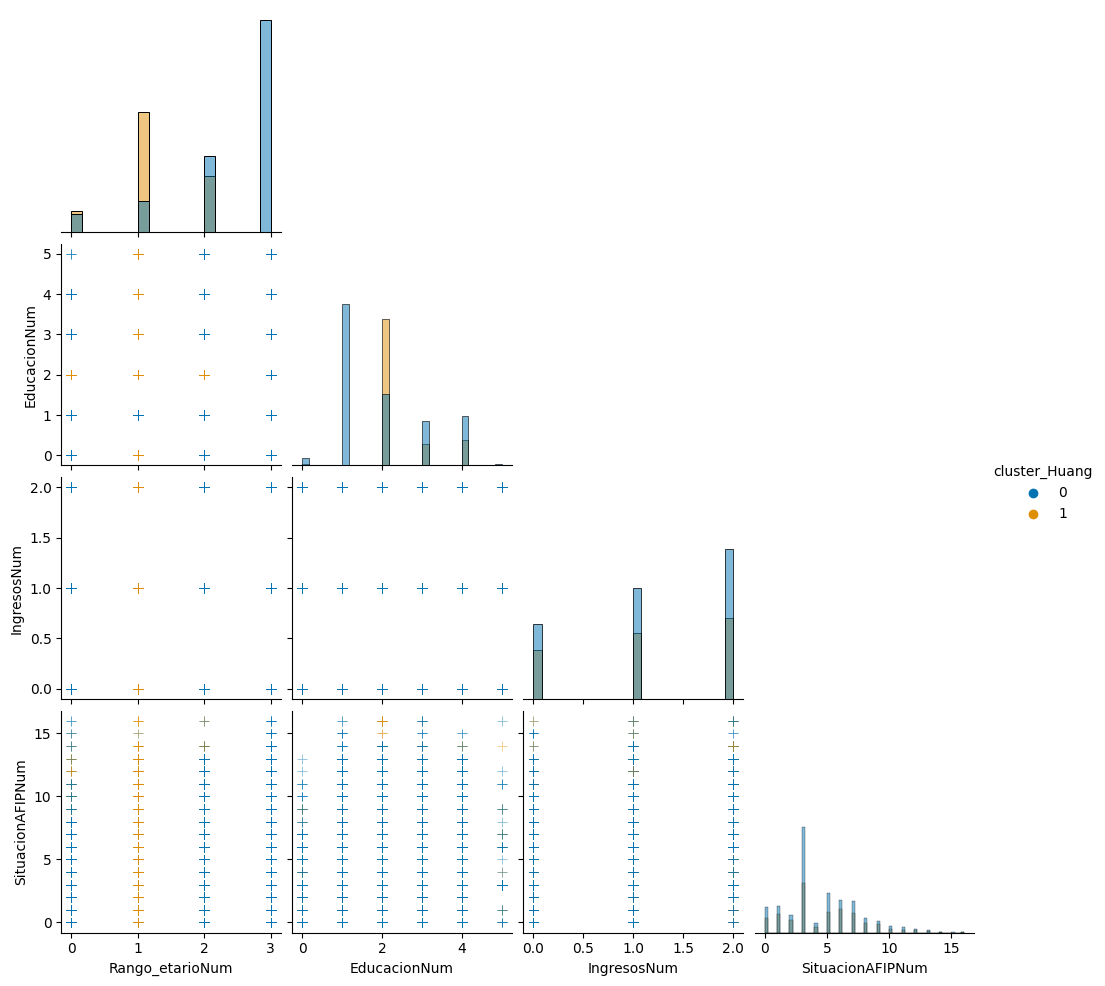

In [43]:
sns.pairplot(data=base_nueva, vars=["Rango_etarioNum", "EducacionNum", "IngresosNum", "SituacionAFIPNum"], hue="cluster_Huang", diag_kind="hist", markers="+", height=2.5, aspect=1, corner=True, plot_kws={"s": 50, "alpha": 0.5}, palette="colorblind")


El siguiente gráfico muestra cuatro subplots que representan el gráfico de dispersión con jitter para diferentes niveles de jitter (0.2, 0.3, 0.4, 0.5) de las variables "IngresosNum" y "SituacionAFIPNum" en función del cluster "cluster_CAO". Esto ayuda a visualizar cómo varía la distribución de los puntos cuando se aplica jitter a los datos.

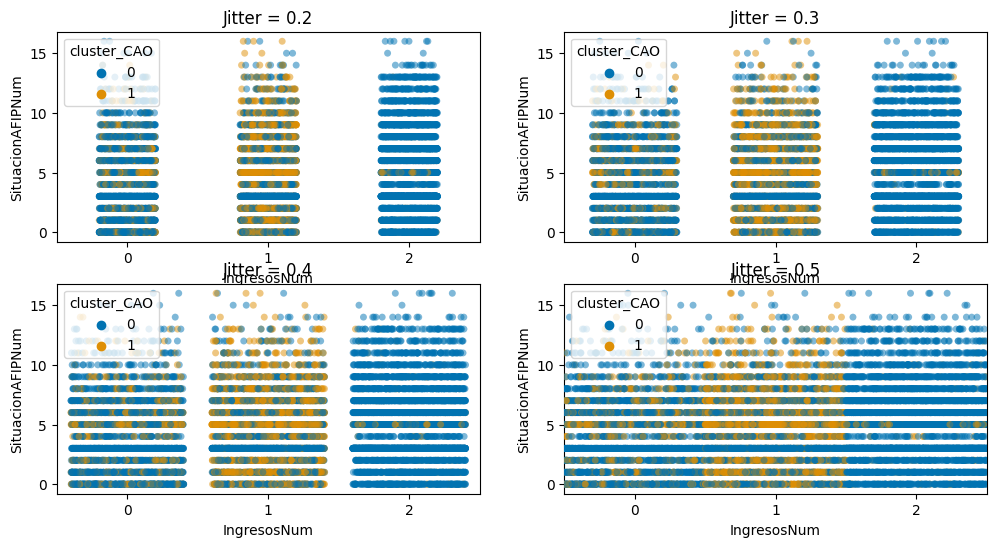

In [44]:
# ************* CAO *******************
# Crear la figura y los subplots
Jitter, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

# Armo los subplots
sns.stripplot(data=base_nueva, x="IngresosNum", y="SituacionAFIPNum", hue="cluster_CAO", palette="colorblind", alpha=0.5, jitter=0.2, ax=axs[0,0])
sns.stripplot(data=base_nueva, x="IngresosNum", y="SituacionAFIPNum", hue="cluster_CAO", palette="colorblind", alpha=0.5, jitter=0.3, ax=axs[0,1])
sns.stripplot(data=base_nueva, x="IngresosNum", y="SituacionAFIPNum", hue="cluster_CAO", palette="colorblind", alpha=0.5, jitter=0.4, ax=axs[1,0])
sns.stripplot(data=base_nueva, x="IngresosNum", y="SituacionAFIPNum", hue="cluster_CAO", palette="colorblind", alpha=0.5, jitter=0.5, ax=axs[1,1])

# Ajustar los títulos y los ejes de cada subplot
axs[0,0].set_title('Jitter = 0.2')
axs[0,1].set_title('Jitter = 0.3')
axs[1,0].set_title('Jitter = 0.4')
axs[1,1].set_title('Jitter = 0.5')

# Ajustar el espacio entre subplots y mostrar la figura
fig.tight_layout()
plt.show()


El siguiente gráfico muestra cuatro subplots que representan el gráfico de dispersión con jitter para diferentes niveles de jitter (0.2, 0.3, 0.4, 0.5) de las variables "IngresosNum" y "SituacionAFIPNum" en función del cluster "cluster_Huang". Esto ayuda a visualizar cómo varía la distribución de los puntos cuando se aplica jitter a los datos.

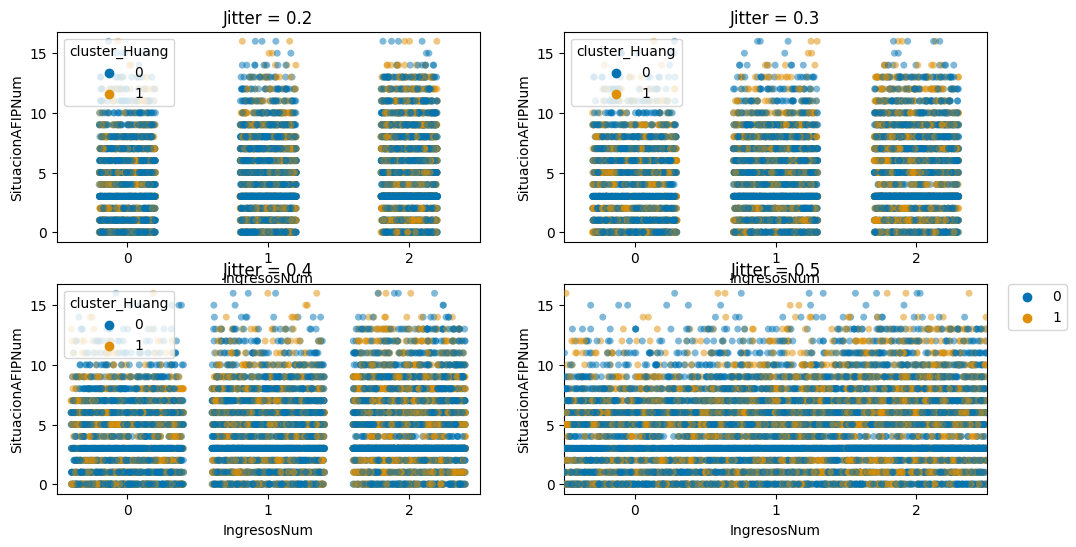

In [51]:
# ****************** Huang ******************
# Crear la figura y los subplots
Jitter, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

# Armo los subplots
sns.stripplot(data=base_nueva, x="IngresosNum", y="SituacionAFIPNum", hue="cluster_Huang", palette="colorblind", alpha=0.5, jitter=0.2, ax=axs[0,0])
sns.stripplot(data=base_nueva, x="IngresosNum", y="SituacionAFIPNum", hue="cluster_Huang", palette="colorblind", alpha=0.5, jitter=0.3, ax=axs[0,1])
sns.stripplot(data=base_nueva, x="IngresosNum", y="SituacionAFIPNum", hue="cluster_Huang", palette="colorblind", alpha=0.5, jitter=0.4, ax=axs[1,0])
sns.stripplot(data=base_nueva, x="IngresosNum", y="SituacionAFIPNum", hue="cluster_Huang", palette="colorblind", alpha=0.5, jitter=0.5, ax=axs[1,1])

# Ajustar los títulos y los ejes de cada subplot
axs[0,0].set_title('Jitter = 0.2')
axs[0,1].set_title('Jitter = 0.3')
axs[1,0].set_title('Jitter = 0.4')
axs[1,1].set_title('Jitter = 0.5')

# Ajustar el espacio entre subplots y mostrar la figura
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


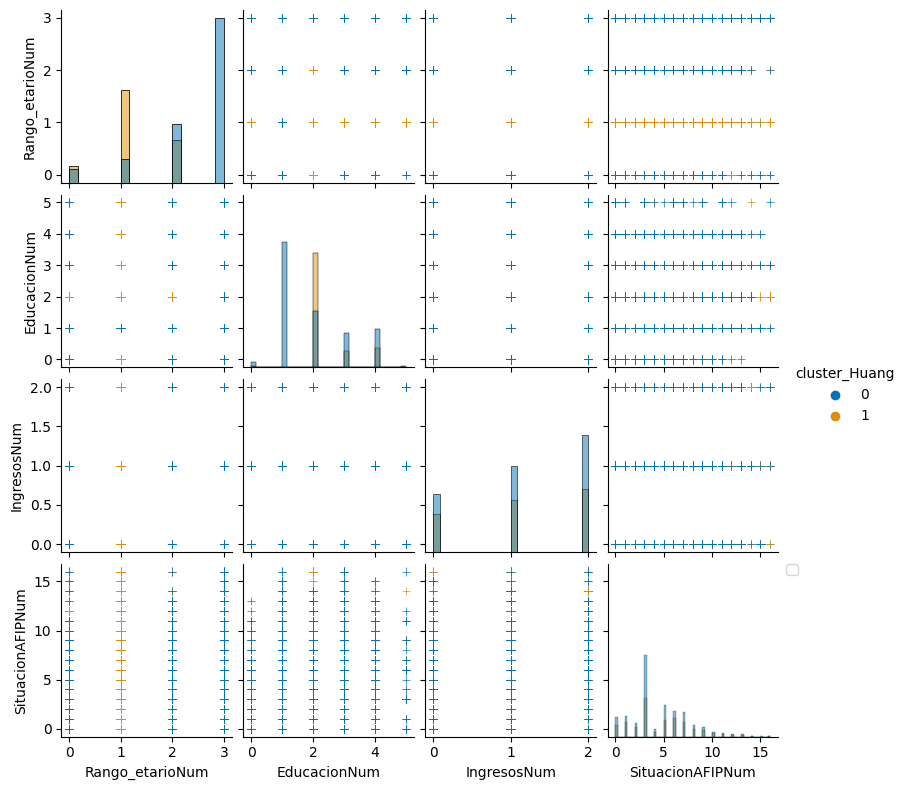

In [52]:
# Seleccionar las variables para el pairplot
variables = ["Rango_etarioNum", "EducacionNum", "IngresosNum", "SituacionAFIPNum"]

# Agregar la columna de cluster como hue
base_nueva["cluster_Huang"] = base_nueva["cluster_Huang"].astype(str)  # Convertir a tipo str para que sea interpretado como categórico
sns.pairplot(data=base_nueva, vars=variables, hue="cluster_Huang", palette="colorblind", diag_kind="hist", markers="+", height=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Mostrar el pairplot
plt.show()

Utilizamos sns.pairplot() para visualizar el resultado con los clusters.
Creamos un gráfico de pares con las variables seleccionadas. La columna de cluster "cluster_Huang" se asigna como el parámetro hue, lo que permitirá diferenciar los puntos de datos por cluster en el gráfico. Se asigna un color a los clusters. El parámetro diag_kind se establece en "hist" para mostrar histogramas en la diagonal principal del pairplot. Los marcadores de los puntos se establecen en +. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


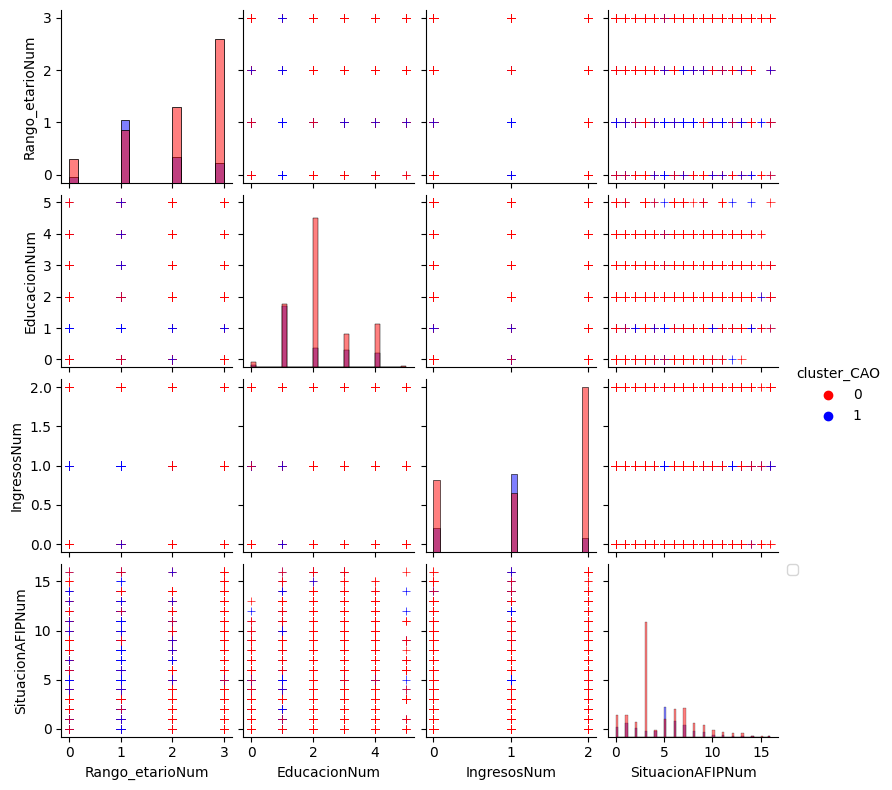

In [57]:
# Seleccionar las variables para el pairplot
variables = ["Rango_etarioNum", "EducacionNum", "IngresosNum", "SituacionAFIPNum"]

# Agregar la columna de cluster como hue
base_nueva["cluster_CAO"] = base_nueva["cluster_CAO"].astype(str)  # Convertir a tipo str para que sea interpretado como categórico
sns.pairplot(data=base_nueva, vars=variables, hue="cluster_CAO", palette=["red", "blue"], diag_kind="hist", markers="+", height=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Mostrar el pairplot
plt.show()